In [1]:
#load libraries
library(fs)
library(readr)
library(tidyverse)
library(dplyr)
library(data.table)
library(ggplot2)

knitr::opts_chunk$set(echo = TRUE, fig.width = 30, fig.height = 10)

#get the list files to use
filenames <- list.files(path = "/kaggle/input/cyclist-analysis-google-capstone-project",pattern="*.csv")
print(filenames)
fullpath=file.path("/kaggle/input/cyclist-analysis-google-capstone-project",filenames)
print(fullpath)
all_rides <- do.call("rbind",lapply(fullpath,FUN=function(files){ read.csv(files)}))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ purrr     1.0.1
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




 [1] "clean_01.csv" "clean_02.csv" "clean_03.csv" "clean_04.csv" "clean_05.csv"
 [6] "clean_06.csv" "clean_07.csv" "clean_08.csv" "clean_09.csv" "clean_10.csv"
[11] "clean_11.csv" "clean_12.csv"
 [1] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_01.csv"
 [2] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_02.csv"
 [3] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_03.csv"
 [4] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_04.csv"
 [5] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_05.csv"
 [6] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_06.csv"
 [7] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_07.csv"
 [8] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_08.csv"
 [9] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_09.csv"
[10] "/kaggle/input/cyclist-analysis-google-capstone-project/clean_10.csv"
[11] "/kaggle/input/cyclist-analysis-google-capstone-pr

As a result, we now have all the observations in "all rides," allowing us to gather pertinent information:

In [2]:
summary(all_rides)

 member_casual      rideable_type       day_of_week        month       
 Length:5667634     Length:5667634     Min.   :1.000   Min.   : 1.000  
 Class :character   Class :character   1st Qu.:2.000   1st Qu.: 5.000  
 Mode  :character   Mode  :character   Median :4.000   Median : 7.000  
                                       Mean   :4.103   Mean   : 7.112  
                                       3rd Qu.:6.000   3rd Qu.: 9.000  
                                       Max.   :7.000   Max.   :12.000  
  ride_length      
 Min.   :    0.00  
 1st Qu.:    6.00  
 Median :   10.00  
 Mean   :   19.45  
 3rd Qu.:   18.00  
 Max.   :41387.00  

Looking closer, we have performed numerous significant calculations, including:
* **5,667,634 observations in total.**
* **The Median ride lasts 10 minutes.**
* **The Average ride lasts 19.45 minutes.**
* **The Maximum ride lasts 41387 minutes.**

As our goal is to compare the usage patterns of members and casual users, I believe we can learn a lot from this if we perform other calculations, such as:
1. The longest ride  in minutes by member type 
2. The mode day of the week by member type
3. Quantiles of ride length by type of member 
4. The mean in minutes by member type
5. Total usage by bike type by member type
6. Total monthly & per day of the week rides by member 
7. Total monthly & per day of the week rides by type of bike

In [3]:
#1 longest ride in minutes by member type, stored in the data frame "max_by_member"
max_by_member <- all_rides %>%
  group_by(all_rides$member_casual) %>%
  summarise(max = max(ride_length, na.rm=TRUE))
print(max_by_member)

# A tibble: 2 × 2
  `all_rides$member_casual`   max
  <chr>                     <int>
1 casual                    41387
2 member                     1560


This data alone doesn't give us much to work with regarding usage per member type, so I opted to use the mode and quantiles functions:

In [4]:
#2 calculate day_of_week mode for all, members and casual rides
mode_dof_all <- names(sort(-table(all_rides$day_of_week)))[1]
mode_dof_members <- names(sort(-table(all_rides$day_of_week[all_rides$member_casual == "member"] )))[1]
mode_dof_casual <- names(sort(-table(all_rides$day_of_week[all_rides$member_casual == "casual"] )))[1]

print(mode_dof_all)
print(mode_dof_members)
print(mode_dof_casual)

[1] "7"
[1] "5"
[1] "7"


We can see that Thursday ("5") is the day when we have the most members riding bikes, while Saturday ("7") has the most casual and overall users. 

In [5]:
#3 calculate quantiles of the usage by member type, stored in 
#"quantile_members" and "quantile_casual" data frames
members <- (filter(all_rides, all_rides$member_casual == "member" )) 
quantile_members <- quantile(members$ride_length)

casuals <- (filter(all_rides, all_rides$member_casual == "casual" ))
quantile_casuals <- quantile(casuals$ride_length)

print(quantile_members)
print(quantile_casuals)

  0%  25%  50%  75% 100% 
   0    5    9   15 1560 
   0%   25%   50%   75%  100% 
    0     7    13    24 41387 


It is evident that the casuals utilize the bicycles for a greater number of minutes, particularly in quantile 3, where there is a difference of 9 minutes between the members' usage times; let's see the difference between the mean for members vs casuals:

In [6]:
#4 mean in minutes by member type, stored in the data frame "mean_by_member"
mean_by_member <- all_rides %>% 
  group_by(all_rides$member_casual) %>% 
  summarise_at(vars(ride_length), list(average = mean))
print(mean_by_member)

# A tibble: 2 × 2
  `all_rides$member_casual` average
  <chr>                       <dbl>
1 casual                       29.1
2 member                       12.7


We can see that, on average, casuals use the bikes for longer periods, what type of bike is the one they prefer to use?

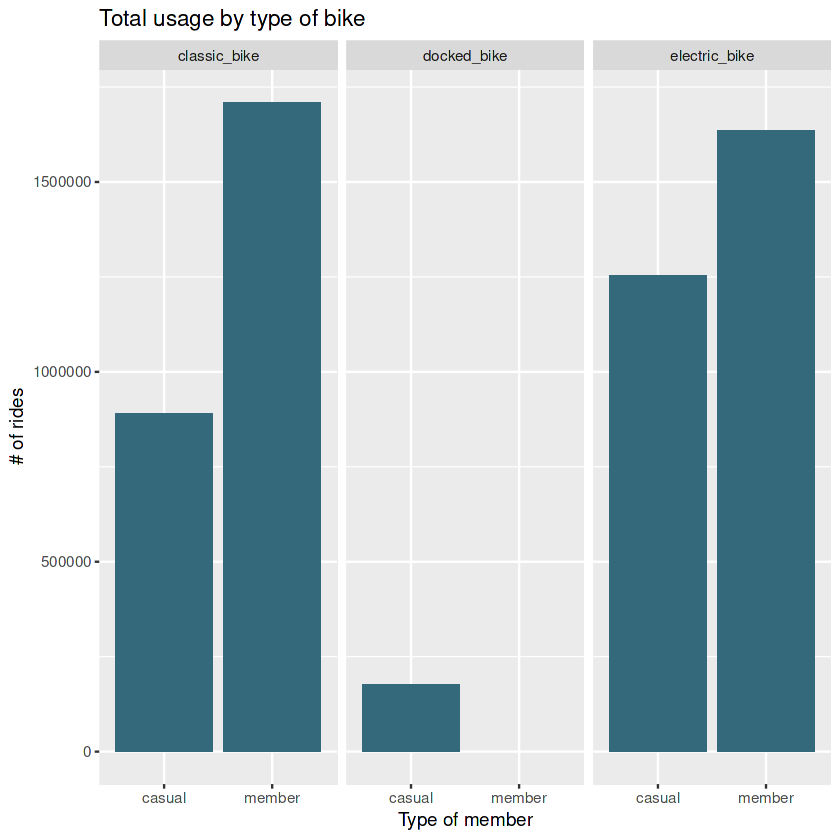

In [7]:
#5 usage by rideable type, stored in the data frame "usage_by_type" and its respective graph
usage_by_type <- all_rides %>% 
  group_by(all_rides$rideable_type) %>% 
  count(all_rides$member_casual , name = 'rides')
 
ggplot(usage_by_type, aes(x = usage_by_type$`all_rides$member_casual`,
                          y = usage_by_type$rides))+
  geom_bar(stat = "identity", fill = "#34697C") +
  facet_wrap(~usage_by_type$`all_rides$rideable_type`) +
  labs(title = "Total usage by type of bike",
       x = "Type of member",
       y = "# of rides",
       fill = "Bike Type")


Now we have discovered that while members do not use the docked bikes, casual users did so 177,474 times during the year, could this be one of the differentiators that helps us convert casual users into members? let's finish the rest of the calculations.

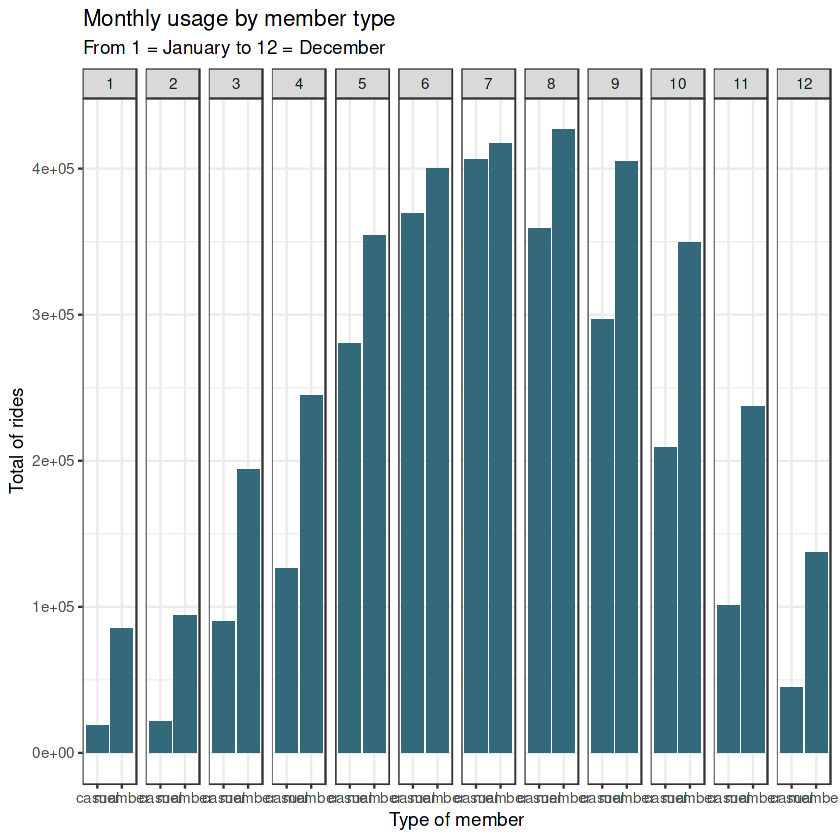

In [8]:
#6a monthly rides by members and casual, stored in the data frame "monthly_by_member"
monthly_by_member <- all_rides %>% 
  group_by(all_rides$month) %>% 
  count(all_rides$member_casual, name = 'rides') %>% 
  set_names( "Month", "Member","Rides")

monthly_by_member %>% 
  ggplot(aes(x = Member, y = Rides))+
  geom_bar(stat = "identity", fill = "#34697C") +
  scale_x_discrete(labels = label_wrap_gen(15))+
  facet_grid(~monthly_by_member$Month) +
  labs(title = "Monthly usage by member type",
       subtitle = "From 1 = January to 12 = December",
       x = "Type of member",
       y = "Total of rides",
       fill = "Bike Type")+
  theme_bw()

In the graph we can see that in the months of May, June, July and August the difference between the use of bicycles by casual users and members decreases, which coincides with the fact that these months are the hottest in Chicago, so it can be be a factor to consider

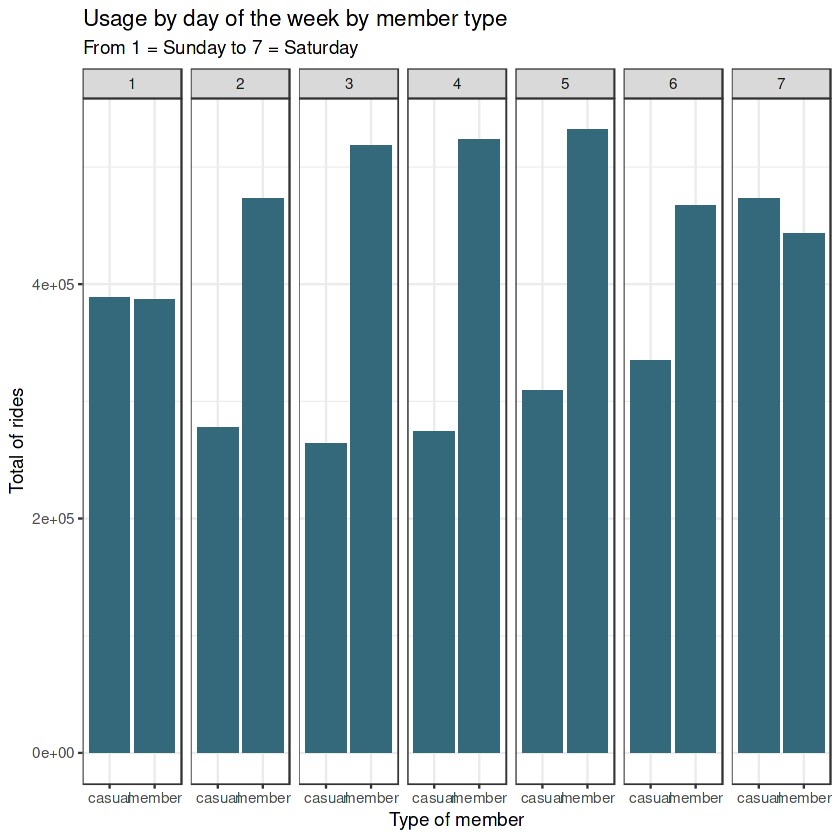

In [9]:
#6b member and casual weekday rides, stored in the data frame "perday_by_member"
perday_by_member <- all_rides %>% 
  group_by(all_rides$day_of_week) %>% 
  count(all_rides$member_casual, name = 'rides') %>% 
  set_names( "Day", "Member","Rides")

perday_by_member %>% 
  ggplot(aes(x = Member, y = Rides))+
  geom_bar(stat = "identity", fill = "#34697C") +
  facet_grid(~perday_by_member$Day) +
  labs(title = "Usage by day of the week by member type",
       subtitle = "From 1 = Sunday to 7 = Saturday",
       x = "Type of member",
       y = "Total of rides",
       fill = "Bike Type")+
  theme_bw() 

Regarding the use per day, on Saturday and Sunday casual users are the ones who use the service the most, this may be an indicator of being for a more recreational use than as a means of transportation

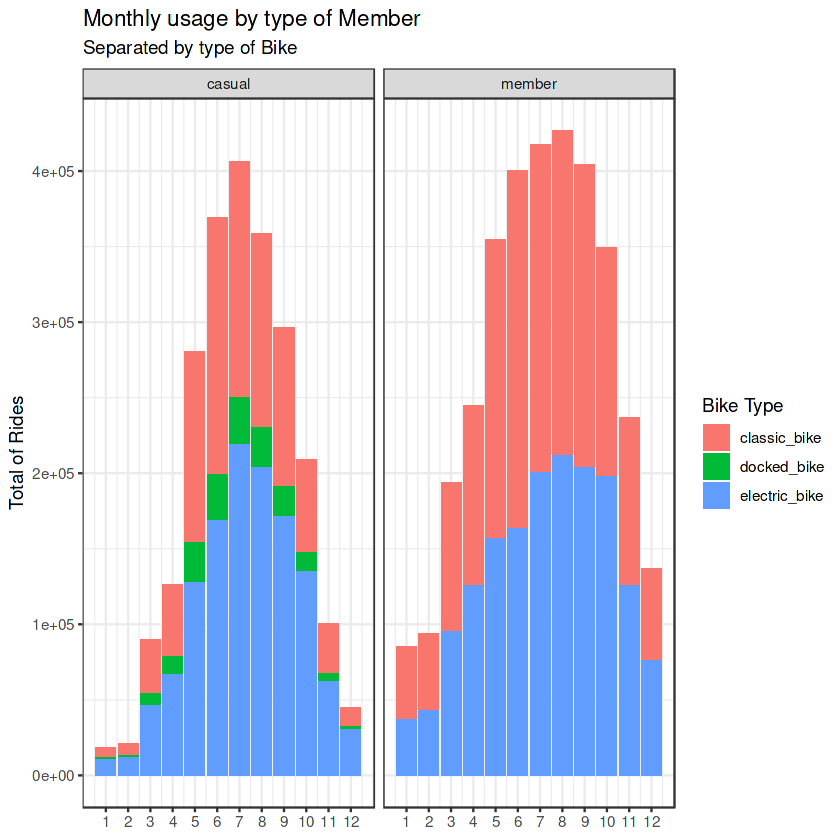

In [10]:
#7a monthly rides by rideable type, stored in the data frame "monthly_by_type"
monthly_by_type <- all_rides %>% 
  group_by(all_rides$month, all_rides$member_casual) %>% 
  count(all_rides$rideable_type, name = 'rides') %>% 
  set_names( "Month","Member", "Bike","Rides")

monthly_by_type %>% 
  ggplot(aes(x = Month, y = Rides, fill = Bike ))+
  geom_bar(stat = "identity") +
  facet_grid(~Member)+ 
  scale_x_continuous(breaks = c(1,2,3,4,5,6,7,8,9,10,11,12))+
  labs(title = "Monthly usage by type of Member",
       subtitle = "Separated by type of Bike",
       x = NULL,
       y = "Total of Rides",
       fill = "Bike Type")+
  theme_bw()

Looking at the graphs side by side we notice a strong preference for electric bikes by casual users, while members, in addition to not using docked_bikes, use a 50 / 50 between the classic and the electric ones 

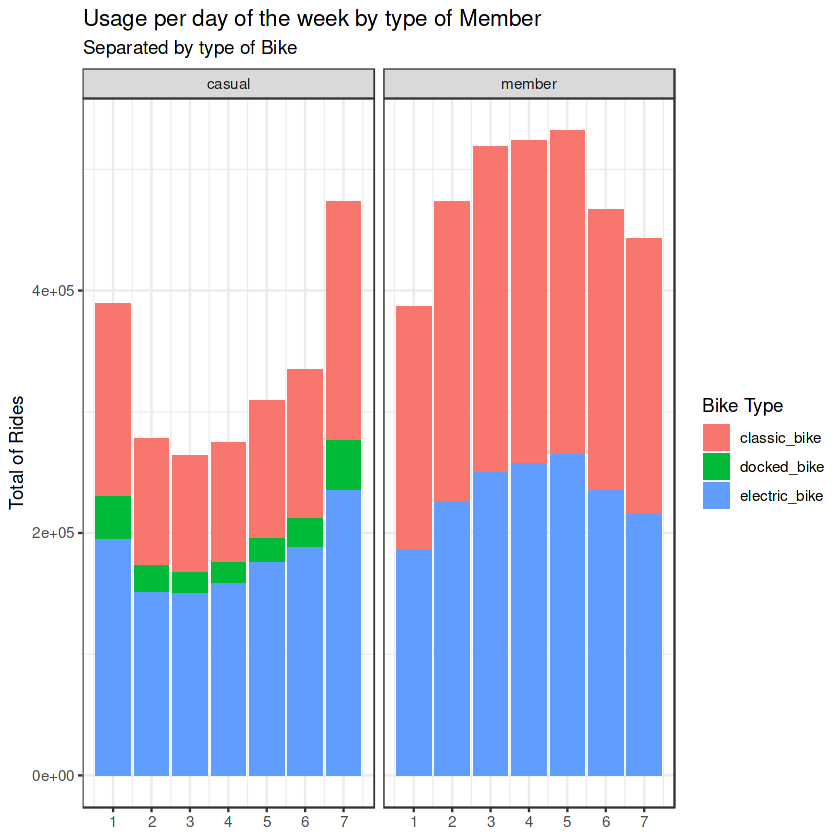

In [11]:
#7b weekday rides by rideable type, stored in the data frame "perday_by_type"
perday_by_type <- all_rides %>% 
  group_by(all_rides$day_of_week, all_rides$rideable_type) %>% 
  count(all_rides$member_casual, name = 'rides') %>% 
  set_names( "Day","Bike", "Member","Rides")
 
perday_by_type %>% 
  ggplot(aes(x = Day, y = Rides, fill = Bike))+
  geom_bar(stat = "identity") +
  facet_grid(~Member)+ 
  scale_x_continuous(breaks = c(1,2,3,4,5,6,7))+
  labs(title = "Usage per day of the week by type of Member",
       subtitle = "Separated by type of Bike",
       x = NULL,
       y = "Total of Rides",
       fill = "Bike Type")+
  theme_bw() 

Usage trends by month pretty much repeat themselves when reviewing the graphs by day of the week

My recommendations to achieve a higher conversion from casual users to members according to my analysis are:
* Launch campaigns in April with attractive prices for our annual memberships (something similar to what happens in gyms with the New Year's resolutions)
* Create promotions focused on the use of electric bicycles, of which casual users have a clear preference.